In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering

In [3]:
import sqlite3

conn = sqlite3.connect('../db.sqlite3')

In [4]:
FETCH_BOOK_QUERY = "SELECT `id`, `title`, `publisher`, `author`, `image`, `category_id`, `available` FROM `libraryapp_book` "

book_list = pd.read_sql_query(FETCH_BOOK_QUERY, conn)
book_list.head()

,id,title,publisher,author,image,category_id,available
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0
1,6,DBA,ram,thapa,book/pos6.jpg,2,1
2,7,cryptography,ram,thapa,book/baag.jpg,1,1
3,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7
4,9,Harry Potter and the Philosopher's Stone,Harper Collins Collins,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...,4,24


In [5]:
book_list.count()

id             205
title          205
publisher      205
author         205
image          205
category_id    205
available      205
dtype: int64

In [6]:
# rename book list dataframe columns
books = book_list.rename(
    {'id': 'book_id', 'title': 'book_title', 'image': 'book_image'}, axis=1)
books

,book_id,book_title,publisher,author,book_image,category_id,available
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0
1,6,DBA,ram,thapa,book/pos6.jpg,2,1
2,7,cryptography,ram,thapa,book/baag.jpg,1,1
3,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7
4,9,Harry Potter and the Philosopher's Stone,Harper Collins Collins,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...,4,24
...,...,...,...,...,...,...,...
200,205,"The Devil in the White City: Murder, Magic, an...",New Directions,"Erik Larson, Tony Goldwyn",https://images.gr-assets.com/books/1312066724m...,3,47
201,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26
202,207,The Chronicles of Narnia,Penguin Books Ltd. (London),"C.S. Lewis, Pauline Baynes",https://images.gr-assets.com/books/1449868701m...,3,30
203,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49


In [7]:
books_category = pd.read_sql_query("SELECT `id` as `category_id`, `title` as `category_title`, `image` as `category_image` FROM `libraryapp_bookcategory`", conn)

books_category.head()

,category_id,category_title,category_image
0,1,interseting,bookcategory/download.jpeg
1,2,educational,bookcategory/e1.jpg
2,3,Fiction,https://www.google.com/url?sa=i&url=https%3A%2...
3,4,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...


In [8]:
# merge books and book_category
books_data = pd.merge(books, books_category, on='category_id')
books_data

,book_id,book_title,publisher,author,book_image,category_id,available,category_title,category_image
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg
1,6,DBA,ram,thapa,book/pos6.jpg,2,1,educational,bookcategory/e1.jpg
2,209,Networking,Pearson,Unknown,book/alone-tree-sunset-qe.jpg,2,3,educational,bookcategory/e1.jpg
3,7,cryptography,ram,thapa,book/baag.jpg,1,1,interseting,bookcategory/download.jpeg
4,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7,Fiction,https://www.google.com/url?sa=i&url=https%3A%2...
...,...,...,...,...,...,...,...,...,...
200,197,One for the Money,Penguin Books,Janet Evanovich,https://images.gr-assets.com/books/1316730230m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
201,202,Die Verwandlung,Penguin Books,"Franz Kafka, Stanley Corngold",https://images.gr-assets.com/books/1359061917m...,4,6,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
202,203,The Titan's Curse,Henry Holt & Company,Rick Riordan,https://images.gr-assets.com/books/1361038385m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
203,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...


In [9]:
book_ratings = pd.read_sql_query("SELECT `id`, `rating`, `book_id`, `user_id` from `libraryapp_bookrating` ", conn)
book_ratings.head()

,id,rating,book_id,user_id
0,1,3,5,5
1,2,4,5,6
2,3,4,6,6
3,4,4,5,6
4,5,3,5,5


## Merge boo_list and book_ratings

In [10]:
books_with_rating = pd.merge(books_data, book_ratings, on='book_id')
books_with_rating

,book_id,book_title,publisher,author,book_image,category_id,available,category_title,category_image,id,rating,user_id
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,1,3,5
1,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,2,4,6
2,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,4,4,6
3,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,5,3,5
4,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...
238,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,194,4,8
239,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,207,5,7
240,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,56,4,6
241,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,233,4,8


In [11]:
books_with_rating.groupby('book_title')['rating'].count()

book_title
 The Fellowship of the Ring                                   2
A Christmas Carol                                             2
A Clockwork Orange                                            1
A Feast for Crows                                             2
A Game of Thrones                                             2
                                                             ..
Where the Wild Things Are                                     3
Wicked: The Life and Times of the Wicked Witch of the West    1
Wuthering Heights                                             1
cryptography                                                  4
Анна Каренина                                                 2
Name: rating, Length: 131, dtype: int64

In [12]:
ratings = pd.DataFrame(books_with_rating.groupby('book_title')['rating'].mean())
ratings['total_rating'] = pd.DataFrame(books_with_rating.groupby('book_title')['rating'].count())
ratings

,rating,total_rating
book_title,,
The Fellowship of the Ring,4.500000,2
A Christmas Carol,3.000000,2
A Clockwork Orange,4.000000,1
A Feast for Crows,4.000000,2
A Game of Thrones,3.000000,2
...,...,...
Where the Wild Things Are,4.666667,3
Wicked: The Life and Times of the Wicked Witch of the West,5.000000,1
Wuthering Heights,5.000000,1


## Data Preparation

In [13]:
ratings

,rating,total_rating
book_title,,
The Fellowship of the Ring,4.500000,2
A Christmas Carol,3.000000,2
A Clockwork Orange,4.000000,1
A Feast for Crows,4.000000,2
A Game of Thrones,3.000000,2
...,...,...
Where the Wild Things Are,4.666667,3
Wicked: The Life and Times of the Wicked Witch of the West,5.000000,1
Wuthering Heights,5.000000,1


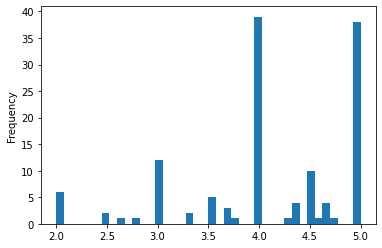

In [14]:
ratings['rating'].plot.hist(bins=40);

In [15]:
user_rating = books_with_rating.groupby('user_id')['rating'].count().clip(upper=50)
user_rating

user_id
5     39
6     50
7     50
8     47
9     45
10     5
11     2
12     1
13     1
14     1
Name: rating, dtype: int64

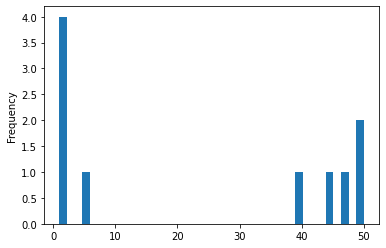

In [16]:
user_rating.plot.hist(bins=40);

# Into Collaborative Filtering
***

Filter Data to reduce Dimensionality

In [17]:
# Minimum book rating to add  that book in books_data.
min_book_rating = 1
filter_books = books_with_rating['book_title'].value_counts() >= min_book_rating
filter_books = filter_books[filter_books].index.tolist()

#  at least user should should rate 2 books to be added
MIN_USER_RATING = 2
filter_users = books_with_rating['user_id'].value_counts() >= MIN_USER_RATING
filter_users = filter_users[filter_users].index.tolist()

books_data = books_with_rating[books_with_rating['book_title'].isin(filter_books) & 
    (books_with_rating['user_id'].isin(filter_users))]
print("Original Shape: {}".format(books_with_rating.shape))
print("Filter Data Shape: {}".format(books_data.shape))
books_data.describe()

Original Shape: (243, 12)
Filter Data Shape: (240, 12)


,book_id,category_id,available,id,rating,user_id
count,240.000000,240.000000,240.000000,240.00000,240.000000,240.000000
mean,102.987500,3.450000,24.412500,120.50000,4.095833,7.125000
std,64.275914,0.657751,15.089713,69.42622,1.003750,1.458276
min,5.000000,1.000000,0.000000,1.00000,1.000000,5.000000
25%,40.500000,3.000000,12.000000,60.75000,4.000000,6.000000
50%,103.000000,4.000000,24.000000,120.50000,4.000000,7.000000
75%,158.500000,4.000000,37.000000,180.25000,5.000000,8.000000
max,208.000000,4.000000,50.000000,240.00000,5.000000,11.000000


## Surprise Library
Load data from `books_data` dataframe to surprise Reader

In [18]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(books_data[['user_id', 'book_title', 'rating']], reader)

Check RMSE, MAE for different algorithms to find best suitable model

In [19]:
benchmark = []
# Iterate over all algorithms
# KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
# NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0817  1.0163  0.8916  0.9965  0.0788  
MAE (testset)     0.7924  0.7971  0.6689  0.7528  0.0594  
Fit time          0.02    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9331  1.0123  1.1052  1.0169  0.0704  
MAE (testset)     0.6919  0.7352  0.8607  0.7626  0.0716  
Fit time          0.10    0.08    0.09    0.09    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2451  1.0753  1.2102  1.1769  0.0732  
MAE (testset)     0.9158  0.8390  0.8825  0.8791  0.0314  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test 

In [42]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.991541,0.760616,0.000558,0.000388
SVD,0.996545,0.752778,0.014667,0.000731
SVDpp,1.016857,0.762597,0.090813,0.002544
KNNWithZScore,1.107154,0.808007,0.000636,0.000792
KNNWithMeans,1.155420,0.840510,0.000565,0.000698
SlopeOne,1.176873,0.879096,0.000828,0.001637
NMF,1.184284,0.919440,0.031583,0.000734
KNNBasic,1.196829,0.844399,0.000175,0.000739
CoClustering,1.224473,0.896550,0.014093,0.000557


From Above, we can see SVD is more suitable in our dataset as it has less RMSE.

# Baselineonly

In [43]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.93546265, 0.94553832, 1.12009363]),
 'fit_time': (0.0003006458282470703,
  0.0027832984924316406,
  0.0004782676696777344),
 'test_time': (0.0005903244018554688,
  0.0006556510925292969,
  0.0006172657012939453)}

In [44]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9509


0.9508885131979511

# Singular Value Decomposition (SVD)
***


## Train & Predict

In [52]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.20)

algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.0175


1.0174893274552077

In [53]:
def get_item_rated_by_user(user_id):
    """ return the number of items rated by given user
    args: 
      user_id: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(user_id)])
    except ValueError: # user was not part of the trainset
        return 0

def get_users_rated_on_item(item_id):
    """ return number of users that have rated given item
    args:
      item_id: the raw id of the item
    returns:a
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(item_id)])
    except ValueError:
        return 0


predictions_data = pd.DataFrame(predictions, columns=['user_id', 'book_title', 'rui', 'est', 'details'])
predictions_data['item_rated_by_user'] = predictions_data.user_id.apply(get_item_rated_by_user)
predictions_data['users_rated_on_item'] = predictions_data.book_title.apply(get_users_rated_on_item)
predictions_data['err'] = abs(predictions_data.est - predictions_data.rui)

In [54]:
predictions_data.head()

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
0,7,Jane Eyre,5.0,4.103123,{'was_impossible': False},39,1,0.896877
1,6,The Road,5.0,3.971847,{'was_impossible': False},39,0,1.028153
2,8,It,4.0,4.150341,{'was_impossible': False},42,2,0.150341
3,5,The Hitchhiker's Guide to the Galaxy,5.0,4.252015,{'was_impossible': False},31,2,0.747985
4,6,Great Expectations,3.0,3.503890,{'was_impossible': False},39,2,0.503890


In [55]:
# def get_Iu(uid):
#     """ return the number of items rated by given user
#     args: 
#       uid: the id of the user
#     returns: 
#       the number of items rated by the user
#     """
#     try:
#         return len(trainset.ur[trainset.to_inner_uid(uid)])
#     except ValueError: # user was not part of the trainset
#         return 0
    
# def get_Ui(iid):
#     """ return number of users that have rated given item
#     args:
#       iid: the raw id of the item
#     returns:
#       the number of users that have rated the item.
#     """
#     try: 
#         return len(trainset.ir[trainset.to_inner_iid(iid)])
#     except ValueError:
#         return 0
    
# df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
# df['Iu'] = df.uid.apply(get_Iu)
# df['Ui'] = df.iid.apply(get_Ui)
# df['err'] = abs(df.est - df.rui)
# df['err'] = abs(df.est - df.rui)

In [56]:
# df.head()

In [57]:
best_predictions = predictions_data.sort_values(by='err')[:10]
worst_predictions = predictions_data.sort_values(by='err')[-10:]


In [58]:
best_predictions

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
26,6,Un di Velt Hot Geshvign,4.0,3.994921,{'was_impossible': False},39,1,0.005079
42,7,A Feast for Crows,4.0,3.990937,{'was_impossible': False},39,0,0.009063
37,6,Harry Potter and the Chamber of Secrets,4.0,3.990188,{'was_impossible': False},39,2,0.009812
7,6,The Devil Wears Prada,4.0,3.971847,{'was_impossible': False},39,0,0.028153
32,6,Harry Potter and the Philosopher's Stone,4.0,3.940105,{'was_impossible': False},39,1,0.059895
5,7,Where the Wild Things Are,4.0,4.063870,{'was_impossible': False},39,1,0.063870
2,8,It,4.0,4.150341,{'was_impossible': False},42,2,0.150341
35,6,DAA,4.0,3.839517,{'was_impossible': False},39,5,0.160483
15,10,The Hunger Games,4.0,4.176142,{'was_impossible': False},4,2,0.176142
34,5,A Feast for Crows,4.0,4.183565,{'was_impossible': False},31,0,0.183565


In [59]:
worst_predictions

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
28,6,Allegiant,5.0,3.971847,{'was_impossible': False},39,0,1.028153
1,6,The Road,5.0,3.971847,{'was_impossible': False},39,0,1.028153
23,6,Harry Potter and the Goblet of Fire,5.0,3.971847,{'was_impossible': False},39,0,1.028153
36,6,The Book Thief,5.0,3.971847,{'was_impossible': False},39,0,1.028153
45,9,The Handmaid's Tale,3.0,4.445718,{'was_impossible': False},35,2,1.445718
8,6,The Hobbit or There and Back Again,2.0,3.971847,{'was_impossible': False},39,0,1.971847
39,6,DBA,2.0,4.026276,{'was_impossible': False},39,2,2.026276
38,8,Of Mice and Men,2.0,4.207814,{'was_impossible': False},42,1,2.207814
10,9,Fifty Shades Freed,2.0,4.278828,{'was_impossible': False},35,0,2.278828
29,5,A Christmas Carol,1.0,4.396119,{'was_impossible': False},31,1,3.396119


In [60]:
predictions_data[predictions_data['est'] < 4]

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
1,6,The Road,5.0,3.971847,{'was_impossible': False},39,0,1.028153
4,6,Great Expectations,3.0,3.503890,{'was_impossible': False},39,2,0.503890
7,6,The Devil Wears Prada,4.0,3.971847,{'was_impossible': False},39,0,0.028153
8,6,The Hobbit or There and Back Again,2.0,3.971847,{'was_impossible': False},39,0,1.971847
11,7,The Scarlet Letter,4.0,3.757276,{'was_impossible': False},39,2,0.242724
18,7,Pride and Prejudice,5.0,3.990937,{'was_impossible': False},39,0,1.009063
23,6,Harry Potter and the Goblet of Fire,5.0,3.971847,{'was_impossible': False},39,0,1.028153
25,7,Something Borrowed,5.0,3.990937,{'was_impossible': False},39,0,1.009063
26,6,Un di Velt Hot Geshvign,4.0,3.994921,{'was_impossible': False},39,1,0.005079
27,7,Le Petit Prince,3.0,3.989649,{'was_impossible': False},39,1,0.989649


In [61]:
predictions_data[predictions_data['rui'] < 3]

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
8,6,The Hobbit or There and Back Again,2.0,3.971847,{'was_impossible': False},39,0,1.971847
10,9,Fifty Shades Freed,2.0,4.278828,{'was_impossible': False},35,0,2.278828
29,5,A Christmas Carol,1.0,4.396119,{'was_impossible': False},31,1,3.396119
38,8,Of Mice and Men,2.0,4.207814,{'was_impossible': False},42,1,2.207814
39,6,DBA,2.0,4.026276,{'was_impossible': False},39,2,2.026276


In [62]:
books_data.loc[books_data['book_title'] == "DAA"]['rating']

0    3
1    4
2    4
3    3
4    4
5    4
Name: rating, dtype: int64

(240, 12)